# Dimensionality Reduction

In [1]:
from src.preprocessing import load_data, get_statistics, fill_empty_values
from src.outlier import interquartile_range
from src.visualize import get_histograms, get_boxplot, get_clients_map
from src.normalize import normalize, check_norm, centering
from pathlib import Path
from src.decomposition import (svd, get_svd_info, get_metrics, low_rank_approx, get_coefficient_matrix,
                               multidimensional_scaling, prepare_coefficients, get_gram_column_matrix, 
                               get_diagonal_eigenvalues_matrix, get_embbeding_spaces_error)
from src.distance_metric import pairwise_minkowski_distance
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = Path('data')
file_path = data_path / '23MAG_HW_1_v1.xls'

In [3]:
dataset = load_data(file_path)

In [4]:
get_statistics(dataset)

,Statistic,Age,Number of dependents,Salary,Years of stay in the region,Car price,Amount of credit
0,Mean,39.3,2.09,19861.76,10.10,20852.94,198492.54
1,Median,38.0,2.00,20250.00,9.00,20500.00,200000.00
2,Std,8.7,1.00,10169.34,4.93,10692.81,99837.35
3,Quantile (25%),34.0,1.00,11125.00,7.00,12000.00,118000.00
4,Quantile (50%),38.0,2.00,20250.00,9.00,20500.00,200000.00
5,Quantile (75%),46.0,3.00,27125.00,14.00,28000.00,265500.00


Fast Data Notes:

The `mean` and `median` metrics of data is about the same. It means that our data has a quite symmetrical distribution.

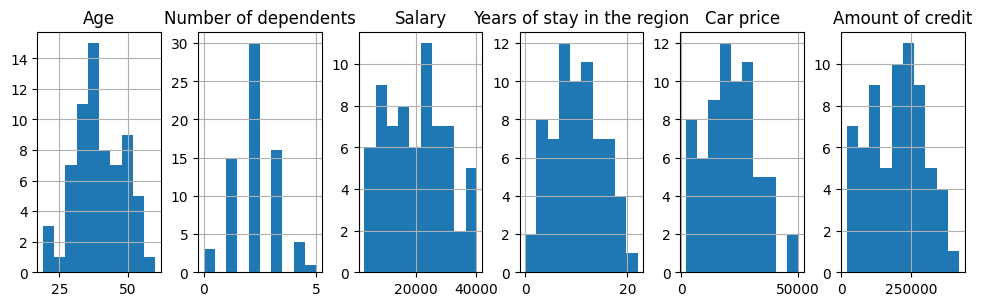

In [5]:
get_histograms(dataset)

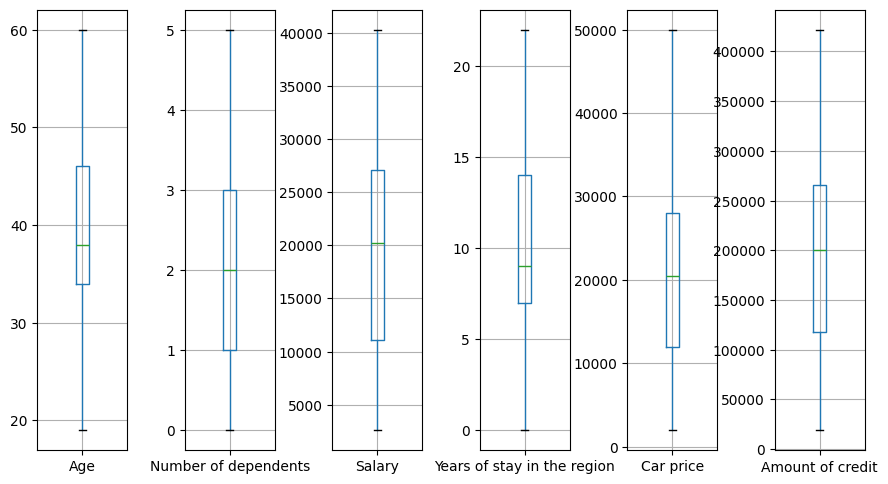

In [6]:
get_boxplot(dataset)

These boxplots shows that our data has outliers in columns `Number of dependents` and `Car price` which we will determine and delete.

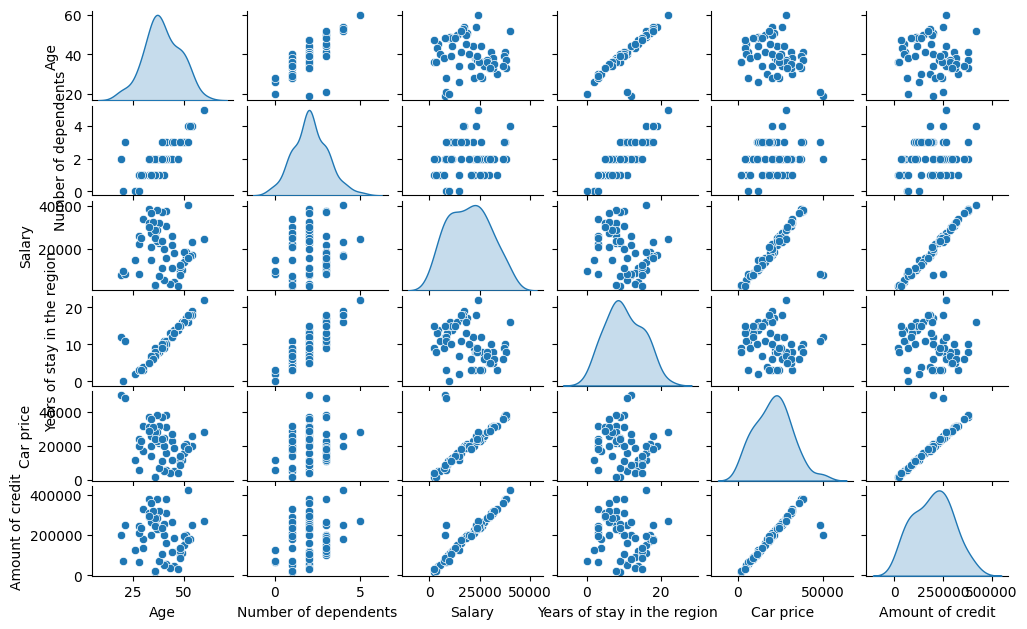

In [7]:
g = sns.pairplot(data=dataset, diag_kind="kde")
g.fig.set_figwidth(10)
g.fig.set_figheight(6)


We can see the strong linear dependency of 

```
* Age        -> Years stay in the region
* Salary     -> Car price
* Car price  -> Amount of credit
```

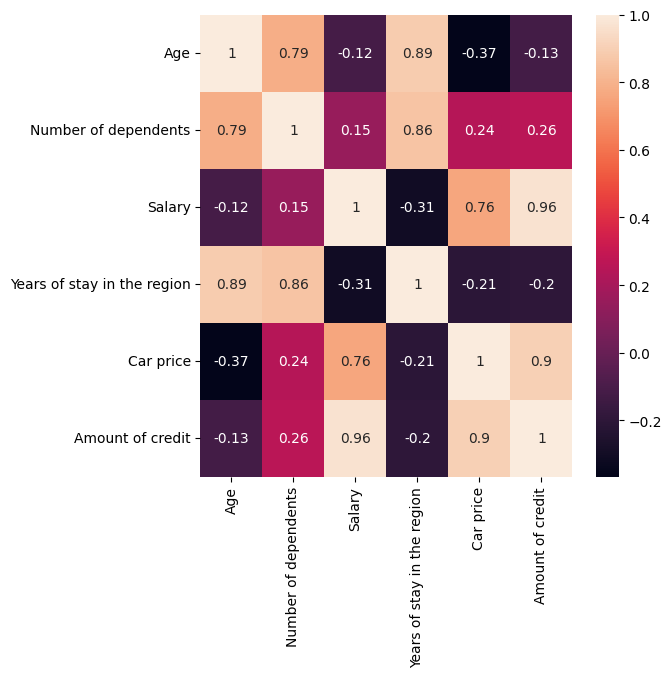

In [8]:
corr = dataset.corr(method='pearson')
plt.figure(figsize=(6, 6))
_ = sns.heatmap(corr, annot=True)

We fill empty values in `Age`, `Salary`, `Years of stay in the region`, `Car price`, and `Amount of credit` as mean.

The missed data in column `Number of dependents` is filled by median value due to semantic applicability of this strategy.

In [9]:
dataset = fill_empty_values(dataset)

To perform outlier removal `Interquartile Range` is offered. It removes data that is out of distribution and keep the data between the $75^{th}$ and $25^{th}$ percentiles.

In [10]:
dataset = interquartile_range(dataset, verbose=True)

The outlier data detected 
 -------------------------
Age                            0
Number of dependents           1
Salary                         0
Years of stay in the region    0
Car price                      1
Amount of credit               0
------------------------- 
 Total deleted rows: 2


The following step for data centering and normalizing

In [11]:
data_z = normalize(centering(dataset))
matrix_z = data_z.to_numpy()
check_norm(data_z)

,Column_name,Euclidean norm
0,Age,1.0
1,Number of dependents,1.0
2,Salary,1.0
3,Years of stay in the region,1.0
4,Car price,1.0
5,Amount of credit,1.0


## Principal Component Analysis

In [12]:
matrix_u, singular_values, matrix_v = svd(matrix_z)
get_svd_info(singular_values)

,0
Singular values,"[1.76, 1.57, 0.53, 0.27, 0.23, 0.19]"
Total variance,6.0
Explained variances,"[0.52, 0.41, 0.05, 0.01, 0.01, 0.01]"
Explained variance (via 1 components),0.52
Explained variance (via 2 components),0.93
Explained variance (via 3 components),0.97
Explained variance (via 4 components),0.98
Explained variance (via 5 components),0.99


From this analysis we could find that our data could be explained via 2 components within 7% explained variance drop.

Therefore in the next steps we will use decomposition rank equal to 2. 

In [13]:
decomposition_rank = 2 

In [14]:
approximated_matrix_z = low_rank_approx(matrix_u, singular_values, matrix_v, precision=decomposition_rank)
get_metrics(matrix_z, approximated_matrix_z)

,Norm,Result
0,Frobenius norm,0.44
1,Spectral norm,0.53
2,Relative Frobenius norm,0.07


Here we construct `approximate_matrix_z` using the matrixs `u`, `v` and the `singular_values` from SVD decomposition of the `marix_z`. In particular, we use only two main factors, which find in the privious step.

After computation of `approximate_matrix_z` we give an error estimations in different norms (e.g. Forbenius and Spectral norm)

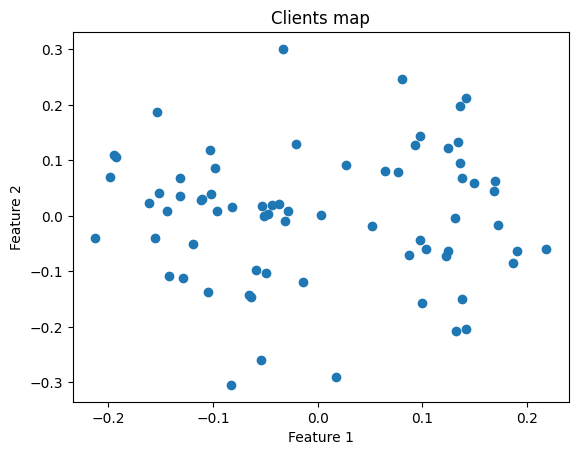

In [15]:
embeddings_pca = matrix_u[:,:decomposition_rank]
get_clients_map(embeddings_pca)

### Hidden Factor Interpretation

`Feature 1` as we can see below has a large negative correlation with `salary`, `amount of credit` and `car price` features. Therefore we can assume that than larger is `Feature 1` the less `salary`, `car price` and `amount of credit`. Lets `Feature 1` reflects some financial factor of clients.

`Feature 2` as we can see below has lage correlation with `number of dependents`, `age` and `years of stay in the region` features. Therefore we can assume that than larger `Feature 2` the larger `number of dependents`, `age` and `years of stay in the region`. Lets `Feature 2` reflect some settlement factor of clients.

$Z_j = (S_1 * V_{1,j} * U_1) + (S_2 * V_{2,j} * U_2)$

In [16]:
coefficient_matrix = get_coefficient_matrix(singular_values, matrix_v, decomposition_rank)
approximated_matrix = matrix_u[:,:2] @ coefficient_matrix

prepare_coefficients(coefficient_matrix)

,Age,Number of dependents,Salary,Years of stay in the region,Car price,Amount of credit
0,0.68,0.32,-0.83,0.73,-0.82,-0.80
1,0.66,0.91,0.47,0.66,0.48,0.55


In this step we calculate the coefficients of main factors (principal component) influence on the our features. In firts row we see the coefficient correlation between $U_1$ and $Z_j$, $j=1,\ldots, 6$. In the second row we can see the coefficient correlation between $U_2$ and $Z_j$, $j=1, \ldots, 6$. 

As result `coefficient_matrix` in reflects the correlation between vectors $Z_j$ where $j=1, \ldots, num\_features$ and $U_i, where i=1,\ldots, decomposition\_rank$

## Dimensionality reduction with MDS

In [17]:
distances_matrix = pairwise_minkowski_distance(matrix_z, 2)
distances_matrix.round(2)

array([[0.  , 0.3 , 0.05, ..., 0.19, 0.06, 0.37],
       [0.3 , 0.  , 0.29, ..., 0.37, 0.31, 0.22],
       [0.05, 0.29, 0.  , ..., 0.21, 0.03, 0.35],
       ...,
       [0.19, 0.37, 0.21, ..., 0.  , 0.22, 0.51],
       [0.06, 0.31, 0.03, ..., 0.22, 0.  , 0.36],
       [0.37, 0.22, 0.35, ..., 0.51, 0.36, 0.  ]])

Here we choose a minkowski distance with $p = 2$ as distance function between vectors representing our clients. That is equals to Euclidean distance function. Due to the low dimension of `matrix_z` we proposed to use the Euclidean distance. However, it is possible to conduct experiments with $p$ difference from $2$.

In the next step we need to constract Gram matrix as $Z^T\cdot Z$ and check would be $Z^T\cdot Z$ is non-negative define. If it is, it is possible to put our spaces to Euclidean space of dimension 2. For this we find eigenvalues of $Z^T\cdot Z$ and take only first two rows of matrix consisting of the eigenvalues. The resulting matrix of dimension (2, 6) is matrix which transform vectors of our spaces to Euclidean space of dimension 2 with distance saving. 

Note that the remaining not equal to zero eigenvalues will influence on error of our transform.

In [18]:
gram_matrix = get_gram_column_matrix(matrix_z)
gram_matrix

array([[ 1.        ,  0.77055316, -0.18597366,  0.89440381, -0.29976873,
        -0.15926849],
       [ 0.77055316,  1.        ,  0.12939196,  0.83038625,  0.207709  ,
         0.21726494],
       [-0.18597366,  0.12939196,  1.        , -0.31732274,  0.81991259,
         0.92917799],
       [ 0.89440381,  0.83038625, -0.31732274,  1.        , -0.25580132,
        -0.2199556 ],
       [-0.29976873,  0.207709  ,  0.81991259, -0.25580132,  1.        ,
         0.88200128],
       [-0.15926849,  0.21726494,  0.92917799, -0.2199556 ,  0.88200128,
         1.        ]])

So we get gram_matrix via columns. Lets check would be the matrix is non-negative define. For this we find the eigenvalues and sure that all of them are non-negative. If it is construct diagonal matrix consisting from eigenvalues of the gram_matrix.

In [19]:
diagonal_eigenvalues_gram_matrix = get_diagonal_eigenvalues_matrix(gram_matrix)
diagonal_eigenvalues_gram_matrix

array([[3.09579275, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 2.46283162, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27850206, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.03772365, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.05402403,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0711259 ]])

So we get diagonal matrix consisting from eigenvalues of the gram matrix. `All eigen values are non-negative hence we could put the our feature space to Euclidean space of dimension 2 with some error`. Error calculate like sum of remaining (4) eigenvalues in power 2.

Note that we also could put our spaces in Euclidean space of dimension from 3 to 6 with less error.

In [20]:
transform_matrix = diagonal_eigenvalues_gram_matrix[:2]
transform_matrix

array([[3.09579275, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 2.46283162, 0.        , 0.        , 0.        ,
        0.        ]])

In [21]:
spaces_embedding_error = get_embbeding_spaces_error(diagonal_eigenvalues_gram_matrix)
spaces_embedding_error

0.08696395921241218

So using `transform_matrix` we could put our spaces in Euclidean spaces dimension 2 with error equal to 0.00362236863158108.

Stress value: 1.9


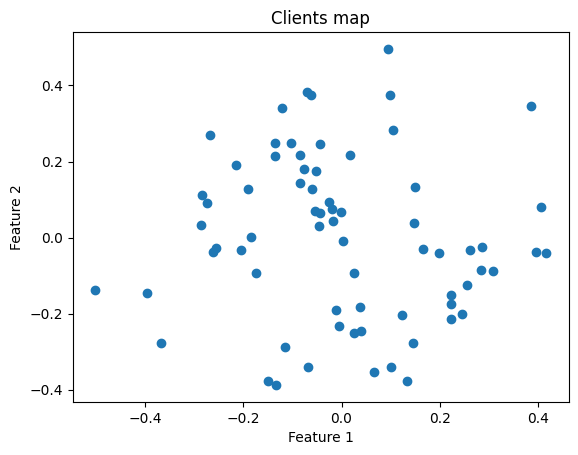

In [22]:
embeddings_mds = multidimensional_scaling(matrix_z, verbose=True)
get_clients_map(embeddings_mds)

We can see that this matrix is the rotated feature map from SVD